<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/ResearchAdmin/NIH_IC_FY25_vs_FY24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# FY2025 Spending Analysis

This notebook pulls **extramural** award **total costs** from the NIH RePORTER (v2) Projects API, aggregates by **Funding IC** for **FY2025** (to date) and for the full **FY2024**, and plots the **FY2025** numbers as a percent of **FY2024** totals.

### Logic used
NIH's API caps pagination at offset ≤ 14,999 (with limit 500). Large, all‑NIH queries can hit that ceiling. So we "chunk" requests by IC using `agencies` + `is_agency_funding=true`. If any single IC still exceeds the offset cap, we ther split by activity‑code buckets and sum the parts (some niche IC-specific mechanisms might be missed in this latter route, but those should be small).


In [ ]:

#@title Setup
!pip -q install requests pandas matplotlib

import math, time, random
import requests
import pandas as pd
import matplotlib.pyplot as plt

API = "https://api.reporter.nih.gov/v2/projects/search"
PAGE_SIZE = 500     # API max per page
TIMEOUT   = 120     # seconds per request
MAX_RETRIES = 5     # transient errors
BACKOFF_BASE = 1.5

print("Environment ready. Using API:", API)


Environment ready. Using API: https://api.reporter.nih.gov/v2/projects/search


In [ ]:
#@title Parameters
FY_24 = 2024  #@param {type:"number"}
FY_25 = 2025  #@param {type:"number"}

# Funding mechanisms to include (EXCLUDES 'IM' intramural by design)
FUNDING_MECHANISMS = ["RP","SB","RC","OR","TR","TI","CO","IAA","SRDC","Other"]

# NIH ICs that regularly issue R01 grants
IC_AGENCIES = [
    "NCI","NIAID","NIAMS","NHLBI","NINDS","NIDDK","NIGMS","NIMH","NIA","NICHD",
    "NIDA","NIEHS","NEI","NIDCR","NINR","NIBIB","NIMHD","NHGRI","NCCIH","NIDCD",
    "NIAAA"
]

# Activity-code buckets (used only if an IC+FY result would exceed the offset cap)
ACTIVITY_BUCKETS = [
  ["R01","R21","R03","R15","R35","R34","R61","R33","RM1","RL1","RF1"],
  ["U01","U19","U54","UM1","UG3","UH3","U24","U18","U2C","OT2","OT3","OT1"],
  ["P01","P30","P50","P20","P60","P40"],  # Centers/programs
  ["K01","K08","K23","K25","K99","K12","KL2"],  # Career development
  ["T32","T35","R25","F31","F32","F30"]      # Training/Fellowship
]

print(f"FY_24={FY_24}, FY_25={FY_25}")
print("ICs (Funding Agencies):", ", ".join(IC_AGENCIES))


FY_24=2024, FY_25=2025
ICs (Funding Agencies): NCI, NIAID, NIAMS, NHLBI, NINDS, NIDDK, NIGMS, NIMH, NIA, NICHD, NIDA, NIEHS, NEI, NIDCR, NINR, NIBIB, NIMHD, NHGRI, NCCIH, NIDCD, NIAAA


In [ ]:
#@title Definitions
def _post(payload):
    last_err = None
    for attempt in range(1, MAX_RETRIES+1):
        try:
            r = requests.post(API, json=payload, timeout=TIMEOUT)
            if r.status_code >= 400:
                try:
                    msg = r.json()
                except Exception:
                    msg = r.text
                raise requests.HTTPError(f"HTTP {r.status_code}: {msg}")
            return r.json()
        except Exception as e:
            last_err = e
            wait = (BACKOFF_BASE ** attempt) + random.random()
            print(f"Request failed (attempt {attempt}/{MAX_RETRIES}): {e}\n  Retrying in {wait:.1f}s...")
            time.sleep(wait)
    raise last_err

def _safe_list(x):
    return x if isinstance(x, list) else []

def _page_and_harvest(base_payload):
    """Yield records while respecting the offset≤14999 cap."""
    # Discover total
    j0 = _post({**base_payload, "limit": PAGE_SIZE, "offset": 0})
    meta_total = int((j0.get("meta") or {}).get("total") or 0)
    if meta_total == 0:
        return [], 0
    if meta_total > 15000:
        return None, meta_total  # signal: too big (needs further splitting)
    rows = []
    def harvest(results):
        for rec in _safe_list(results):
            if rec.get("subproject_id") is not None:
                continue  # avoid double counting
            for f in _safe_list(rec.get("agency_ic_fundings")):
                rows.append(f)
    # first page
    harvest(j0.get("results"))
    pages = math.ceil(meta_total / PAGE_SIZE)
    for p in range(1, pages):
        j = _post({**base_payload, "limit": PAGE_SIZE, "offset": p*PAGE_SIZE})
        harvest(j.get("results"))
        if p % 10 == 0 or p == pages-1:
            print(f"    processed page {p+1}/{pages} (~{min((p+1)*PAGE_SIZE, meta_total)} records)...")
    return rows, meta_total

def fetch_ic_rows_for_agency_fy(agency, fy, activity_codes=None):
    """Return list of agency_ic_fundings dicts for one Funding Agency and FY.
    If result set > 15,000, returns None and caller should further chunk.
    """
    criteria = {
        "fiscal_years": [int(fy)],
        "funding_mechanism": FUNDING_MECHANISMS,
        "agencies": [agency],
        "is_agency_funding": True
    }
    if activity_codes:
        criteria["activity_codes"] = activity_codes
    payload = {
        "criteria": criteria,
        "include_fields": ["ApplId","SubprojectId","AgencyIcFundings"],
        "sort_field": "appl_id",
        "sort_order": "asc"
    }
    rows, total = _page_and_harvest(payload)
    return rows, total

def aggregate_totals_by_ic_for_fy(fy):
    """Loop over Funding Agencies (ICs), fetch + sum funding totals for that FY.
    Splits by activity buckets only if needed to stay under the offset cap.
    Returns a DataFrame with ic_code, ic_abbrev, ic_name, total_cost.
    """
    all_rows = []
    for agency in IC_AGENCIES:
        print(f"IC {agency} — FY {fy}:")
        rows, total = fetch_ic_rows_for_agency_fy(agency, fy)
        if rows is None:
            print(f"  Result too large (~{total}); chunking by activity buckets...")
            ic_rows = []
            for bucket in ACTIVITY_BUCKETS:
                rows_b, total_b = fetch_ic_rows_for_agency_fy(agency, fy, activity_codes=bucket if bucket else None)
                if rows_b is None:
                    raise RuntimeError(f"Even after activity bucketing, query too large for {agency} FY{fy}. Consider refining buckets.")
                ic_rows.extend(rows_b)
            rows = ic_rows
        # keep only fundings matching FY
        for f in rows:
            if f.get("fy") == int(fy):
                all_rows.append({
                    "ic_code": f.get("code"),
                    "ic_abbrev": f.get("abbreviation"),
                    "ic_name": f.get("name"),
                    "total_cost": float(f.get("total_cost") or 0.0)
                })
    df = pd.DataFrame(all_rows, columns=["ic_code","ic_abbrev","ic_name","total_cost"])
    if df.empty:
        print(f"WARNING: No rows found for FY {fy}.")
        return pd.DataFrame(columns=["ic_code","ic_abbrev","ic_name","total_cost"])
    return df.groupby(["ic_code","ic_abbrev","ic_name"], as_index=False)["total_cost"].sum()


In [ ]:

#@title Fetch & aggregate per-IC totals for FY2024 and FY2025 (to date)
df24 = aggregate_totals_by_ic_for_fy(FY_24)
df25 = aggregate_totals_by_ic_for_fy(FY_25)

df24.to_csv("ic_totals_fy2024.csv", index=False)
df25.to_csv("ic_totals_fy2025_todate.csv", index=False)
print("Saved: ic_totals_fy2024.csv, ic_totals_fy2025_todate.csv")

merged = pd.merge(df24, df25, on=["ic_code","ic_abbrev","ic_name"], how="outer", suffixes=("_fy24","_fy25"))
merged["total_cost_fy24"] = pd.to_numeric(merged["total_cost_fy24"], errors="coerce").fillna(0.0)
merged["total_cost_fy25"] = pd.to_numeric(merged["total_cost_fy25"], errors="coerce").fillna(0.0)
merged["pct_of_fy24"] = (merged["total_cost_fy25"] / merged["total_cost_fy24"]).where(merged["total_cost_fy24"] > 0)

merged_sorted = merged.sort_values("pct_of_fy24", na_position="last")
merged_sorted.to_csv("ic_pct_fy25_vs_fy24.csv", index=False)

display_cols = ["ic_abbrev","ic_name","total_cost_fy24","total_cost_fy25","pct_of_fy24"]
print("\nBottom 5 by % of FY2024:")
display(merged_sorted[display_cols].head(5))
print("\nTop 5 by % of FY2024:")
display(merged_sorted[display_cols].tail(5))


IC NCI — FY 2024:
    processed page 11/25 (~5500 records)...
    processed page 21/25 (~10500 records)...
    processed page 25/25 (~12167 records)...
IC NIAID — FY 2024:
    processed page 11/17 (~5500 records)...
    processed page 17/17 (~8258 records)...
IC NIAMS — FY 2024:
    processed page 4/4 (~1674 records)...
IC NHLBI — FY 2024:
    processed page 11/14 (~5500 records)...
    processed page 14/14 (~6654 records)...
IC NINDS — FY 2024:
    processed page 11/11 (~5360 records)...
IC NIDDK — FY 2024:
    processed page 11/11 (~5010 records)...
IC NIGMS — FY 2024:
    processed page 11/18 (~5500 records)...
    processed page 18/18 (~8680 records)...
IC NIMH — FY 2024:
    processed page 8/8 (~3805 records)...
IC NIA — FY 2024:
    processed page 11/14 (~5500 records)...
    processed page 14/14 (~6774 records)...
IC NICHD — FY 2024:
    processed page 8/8 (~3616 records)...
IC NIDA — FY 2024:
    processed page 6/6 (~2782 records)...
IC NIEHS — FY 2024:
    processed page 4/4 (

,ic_abbrev,ic_name,total_cost_fy24,total_cost_fy25,pct_of_fy24
17,NLM,National Library of Medicine,2.366763e+08,5893583.0,0.024901
15,NHGRI,National Human Genome Research Institute,5.360973e+08,327059042.0,0.610074
22,OD,NIH Office of the Director,1.300313e+09,859895046.0,0.661298
24,FIC,John E. Fogarty International Center for Advan...,3.437798e+07,23563739.0,0.685431
20,NINR,National Institute of Nursing Research,1.760471e+08,127858813.0,0.726276



Top 5 by % of FY2024:


,ic_abbrev,ic_name,total_cost_fy24,total_cost_fy25,pct_of_fy24
8,NIDCR,National Institute of Dental and Craniofacial ...,4.200882e+08,3.913650e+08,0.931626
6,NIDA,National Institute on Drug Abuse,1.537869e+09,1.438404e+09,0.935323
13,NIGMS,National Institute of General Medical Sciences,3.135508e+09,2.961260e+09,0.944428
10,NIBIB,National Institute of Biomedical Imaging and B...,3.654276e+08,3.539985e+08,0.968724
4,NCCIH,National Center for Complementary and Integrat...,1.402837e+08,1.419582e+08,1.011937


In [ ]:
#@title Check update date
# Get NIH RePORTER "last update" as the most recent date_added in the index
# We request only 1 record, sorted by date_added desc.
LAST_UPDATE_URL = "https://api.reporter.nih.gov/v2/projects/search"

payload_last = {
    "criteria": {
        # we don't filter here; we just want the latest date_added across the index
        # (optionally could add "newly_added_projects_only": True, but not required)
    },
    "include_fields": ["DateAdded"],  # per NIH include-field name
    "limit": 1,
    "offset": 0,
    "sort_field": "date_added",       # use response (snake_case) name for sort_field
    "sort_order": "desc"
}

resp = requests.post(LAST_UPDATE_URL, json=payload_last, timeout=120)
resp.raise_for_status()
last_update = None
jr = resp.json()
for rec in jr.get("results", []):
    if rec.get("date_added"):
        last_update = rec["date_added"]
        break

print("NIH RePORTER data last update (date_added):", last_update)



NIH RePORTER data last update (date_added): 2025-09-07T22:56:09


Saved figure: ic_pct_fy25_vs_fy24.png


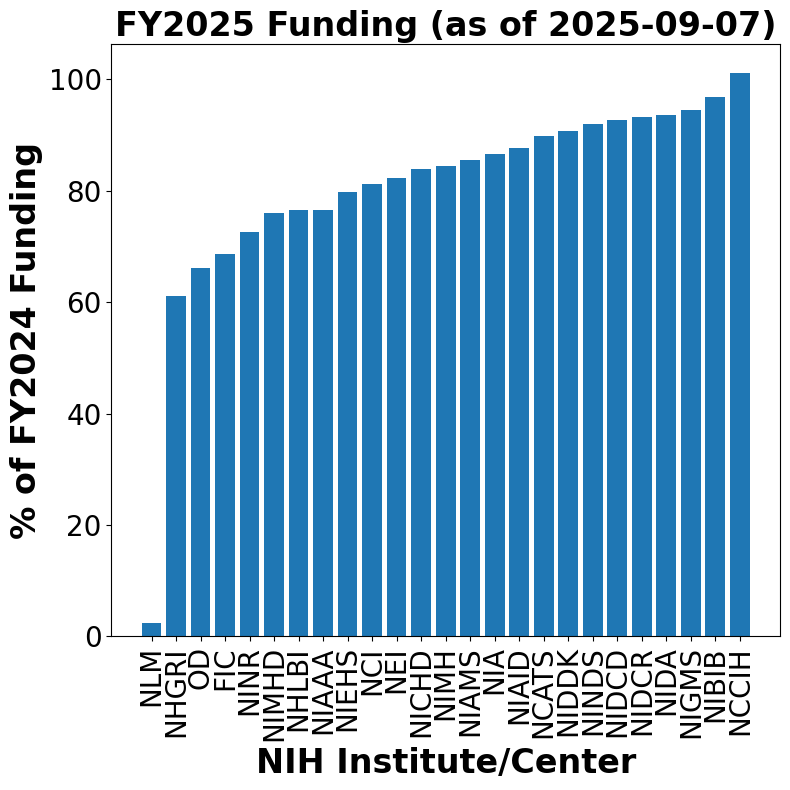

In [ ]:
#@title Plot
import datetime

# Use the last_update date from the API, or fallback to today's date
if last_update:
    # Strip off any time part if present (keep just YYYY-MM-DD)
    label_date = str(last_update).split("T")[0]
else:
    label_date = datetime.date.today().strftime("%Y-%m-%d")

plot_df = merged_sorted.dropna(subset=["pct_of_fy24"]).copy()
plot_df["pct_100"] = plot_df["pct_of_fy24"] * 100.0

# Make figure square and labels larger
plt.figure(figsize=(8, 8))

plt.bar(plot_df["ic_abbrev"], plot_df["pct_100"])

plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("NIH Institute/Center", fontsize=24, weight="bold")
plt.ylabel("% of FY2024 Funding", fontsize=24, weight="bold")
plt.title(f"FY2025 Funding (as of {label_date})", fontsize=24, weight="bold")

plt.tight_layout()
plt.savefig("ic_pct_fy25_vs_fy24.png", dpi=200)
print("Saved figure: ic_pct_fy25_vs_fy24.png")



In [ ]:
plot_df

,ic_code,ic_abbrev,ic_name,total_cost_fy24,total_cost_fy25,pct_of_fy24,pct_100
17,LM,NLM,National Library of Medicine,2.366763e+08,5.893583e+06,0.024901,2.490145
15,HG,NHGRI,National Human Genome Research Institute,5.360973e+08,3.270590e+08,0.610074,61.007398
22,OD,OD,NIH Office of the Director,1.300313e+09,8.598950e+08,0.661298,66.129831
24,TW,FIC,John E. Fogarty International Center for Advan...,3.437798e+07,2.356374e+07,0.685431,68.543117
20,NR,NINR,National Institute of Nursing Research,1.760471e+08,1.278588e+08,0.726276,72.627622
18,MD,NIMHD,National Institute on Minority Health and Heal...,5.363703e+08,4.071198e+08,0.759027,75.902749
16,HL,NHLBI,National Heart Lung and Blood Institute,4.116991e+09,3.149211e+09,0.764930,76.493015
0,AA,NIAAA,National Institute on Alcohol Abuse and Alcoho...,4.925960e+08,3.772696e+08,0.765880,76.588044
11,ES,NIEHS,National Institute of Environmental Health Sci...,5.887568e+08,4.697202e+08,0.797817,79.781704
5,CA,NCI,National Cancer Institute,4.674409e+09,3.791734e+09,0.811169,81.116855
